## autograd.grad() vs autograd.backward()

autograd is the automatic differentiation package of pyTorch, that contains two ways to calculate the gradients for you. We can obtain identical results for the same input given some tweaks.

`autograd.grad` is a function to be used when you want to explicitly compute gradients and get them as output tensors. It's more flexible and gives you direct access to the gradient values. Whereas, the `backward()` method is a method on tensor objects that will accumulate gradients in the `grad` attribute of tensors and is typically used with optimizers.

In [105]:
import torch
import matplotlib.pyplot as plt

x = torch.arange(-10 , 10, 0.5, requires_grad=True)
y = x**3


The `[0]` is needed with `autograd.grad()` because it returns a tuple of gradients, even when there's only one input tensor. This tuple return is designed to handle cases where you're computing gradients with respect to multiple input tensors. 

If you run `autograd.grad()` or `backward()` more than once on the same tensor with `create_graph=False`, you'll get an error like "Trying to backward through the graph a second time, but the saved intermediate results have already been freed." This is the first call computes the gradients but then frees the computational graph and the second call fails because the graph needed for gradient computation no longer exists. Similarly, for computing multiple different gradients from the same forward pass, use `retain_graph=True`.



The `grad_outputs` (or gradient weights) parameter in `autograd.grad()` specifies how to weight each element when computing gradients for tensors with multiple elements. In the following code, we specifically tell pyTorch to weigh the gradients equally by passing in `torch.ones_like(x)`. Similarly  when using `backward()` with non-scalar outputs (i.e., when your output tensor has multiple elements), you also need to provide gradient weights.

In [ ]:
# first derivative
dy = torch.autograd.grad(y, x, torch.ones_like(x), create_graph=True)[0]

# second derivative
d2y = torch.autograd.grad(dy, x, torch.ones_like(x), create_graph=True)[0]

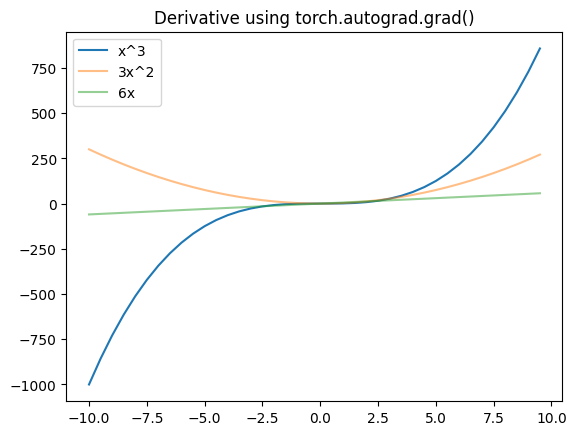

In [107]:
plt.plot(x.detach().numpy(), y.detach().numpy(), label = 'x^3')
plt.plot(x.detach().numpy(),dy.detach().numpy(), label = '3x^2', alpha = 0.5)
plt.plot(x.detach().numpy(),d2y.detach().numpy(), label = '6x', alpha = 0.5)
plt.title('Derivative using torch.autograd.grad()')
plt.legend()

`backward()` requires a bit more finessing to obtain the same gradients. This is because the `backward()` method serves a different purpose and is more common in standard neural network training loops where gradients are accumulated in the `.grad` attribute of parameters for optimization.

This is why you'll typically see backward() used with optimizers in training loops:

```
optimizer.zero_grad()  # Clear accumulated gradients
loss.backward()       # Compute gradients
optimizer.step()      # Update weights
```


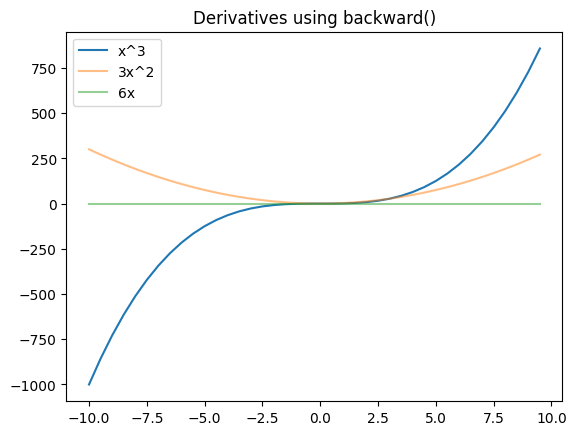

In [108]:
# First derivative with backward()
y.backward(torch.ones_like(x), retain_graph=True)

# Clone before zeroing out!
dy_backward = x.grad.clone()  

# Need to zero out the first gradient and ensure x.grad itself requires grad
x.grad.zero_()
x.grad = torch.zeros_like(x, requires_grad=True)

# Compute second derivative
dy_backward.requires_grad_(True)
dy_backward.backward(torch.ones_like(x))
d2y_backward = x.grad


plt.plot(x.detach().numpy(), y.detach().numpy(), label='x^3')
plt.plot(x.detach().numpy(), dy_backward.detach().numpy(), label='3x^2', alpha=0.5)
plt.plot(x.detach().numpy(), d2y_backward.detach().numpy(), label='6x', alpha=0.5)
plt.title('Derivatives using backward()')
plt.legend()